In [1]:
import numpy as np 
import pandas as pd 
import sys
import math
from datetime import datetime
import calendar

import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['font.family'] = 'NanumGothic'

import seaborn as sns 

import warnings 
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [2]:
train=pd.read_csv("train_final.csv",encoding="euc-kr")

## 변수명 수정

In [3]:
train=train.rename(columns={'stn_id':'area'})

# 변수 설명

- tma: 날짜  
- area: 지역
- sex: 성별(남:1,여:2)  
- frequency: 빈도
- ssrate: 일조율  
- sum_gsr: 합계전천일사  
- avg_pa: 평균기압  
- max_pa: 최고기압  
- min_pa: 최저기압  
- sum_rn: 합계강수량  
- avg_ta: 평균기온  
- max_ta: 최고기온  
- min_ta: 최저기온    
- avg_ws: 평균풍속  
- max_ws: 최대풍속  
- pm10: 미세먼지  
- avg_rhm: 평균상대습도
- elder_rate: 고령인구비율  
- elder: 65세이상인구  
- total_pop: 전체인구  
- fct_rhm:예보 습도  
- fct_max_ta:예보 최고기온  
- fct_min_ta :예보 최저기온   
- year: 년  
- month:월  
- day: 일  
- weekday: 요일
- holidays: 공휴일, 1이면 공휴일,0이면 아님  
- season: 계절
- cold_wave: 1:-12이하, 0:이상  
- heat_wave: 1: 33이상, 0:이하 
- dtr:일교차  
- fct_dtr:예보 데이터 일교차
- dtr_class: 일교차 등급  
- fct_dtr_class:예보 데이터 일교차 등급  
- pm10_class: 미세먼지 등급  
- last_class: 1 :각 달마다 마지막날, 0: 다른 날 
- wind_chill:체감온도  
- stroke:뇌졸중가능지수(1,2,3,4등급)
- elder_rate_class: 고령등급(성숙인구사회,고령화사회,고령사회,초고령사회)  
- EQ:건강관련 삷의 질의 5가지 차원(운동능력,자기관리,일상활동,통증/불편,불안/우울)을 활용하여 만든 지표,1에 가까울수록 삶의 질이 높음   
- obesity: 비만율
- smoking: 흡연율 
- stress:스트레스인지율  
- drink:고위험음주율  
- city:1:수도권&광역시,0:아닌 지역들  

## 예보데이터 기준

충북 - 보은읍  
충남 - 부여읍  
제주 - 성산읍  
전북 - 임실읍  
전남 - 중앙동  
인천 - 동인천동  
울산 - 병영2동  
세종 - 새롬동  
서울 - 교남동  
부산 - 대청동  
대전 - 온천2동  
대구 - 효목1동  
광주 - 운암1동  
경북 - 풍기읍  
경남 - 내이동  
강원 - 인제읍  
경기 - 부발읍    

지도상에서 중앙이 되는 지역으로 설정함 

# NA처리하기 전 필요한 변수들

In [4]:
train['tma']=train[['tma']].astype(str)
train['sex']=train[['sex']].astype(object)

In [5]:
train['year'] = train['tma'].apply(lambda x : x[0:4])
train['month'] = train['tma'].apply(lambda x : x[4:6])
train['day'] = train['tma'].apply(lambda x : x[6:8])

In [6]:
train['year']=train[['year']].astype(str)
train['month']=train[['month']].astype('int64')
train['day']=train[['day']].astype('int64')

# na처리

풍속,기온,일조율,기압,강수량은 사전에 데이터를 합치면서 NA를 처리하고 가져옴  

- 강수량: 0으로 처리함
- 일조율: 울산을 제외한 나머지 지역들은 평균으로 대체함. 울산은 지역 전체가 NA이여서 0으로 대체함.
- 기온,기압,풍속: 평균으로 대체함

## 인구

In [7]:
train.isnull().sum()

tma              0
area             0
sex              0
frequency        0
ssrate           0
sum_gsr          0
avg_pa           0
max_pa           0
min_pa           0
sum_rn           0
avg_ta           0
max_ta           0
min_ta           0
avg_ws           0
max_ws           0
pm10          8900
avg_rhm          4
elder_rate     364
elder          364
total_pop      364
fct_rhm       2448
fct_max_ta    2448
fct_min_ta    2510
year             0
month            0
day              0
dtype: int64

인구 관련 변수들 na를 봤을 때 세종(2012.01.01 - 2012.06.30)만 없다는 것을 확인

In [8]:
train[train['elder_rate'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
18,20120101,세종,1,0,0.0,2.58,1017.5,1019.7,1014.9,1.8,...,55.500000,NaN,NaN,NaN,49.0,1.900000,-6.0,2012,1,1
19,20120101,세종,2,0,0.0,2.58,1017.5,1019.7,1014.9,1.8,...,55.500000,NaN,NaN,NaN,49.0,1.900000,-6.0,2012,1,1
52,20120102,세종,1,0,72.2,8.78,1019.6,1021.9,1017.5,0.0,...,62.600000,NaN,NaN,NaN,60.0,-0.700000,-8.3,2012,1,2
53,20120102,세종,2,0,72.2,8.78,1019.6,1021.9,1017.5,0.0,...,62.600000,NaN,NaN,NaN,60.0,-0.700000,-8.3,2012,1,2
86,20120103,세종,1,2,21.6,6.18,1014.9,1017.6,1011.2,0.1,...,72.937500,NaN,NaN,NaN,40.0,0.700000,-7.1,2012,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,20120628,세종,2,0,32.0,18.54,1005.5,1007.8,1003.7,0.0,...,76.842857,NaN,NaN,NaN,55.0,25.299999,20.5,2012,6,28
6138,20120629,세종,1,0,15.6,18.54,1002.1,1004.9,999.6,0.5,...,77.100000,NaN,NaN,NaN,85.0,28.700001,19.6,2012,6,29
6139,20120629,세종,2,0,15.6,18.54,1002.1,1004.9,999.6,0.5,...,77.100000,NaN,NaN,NaN,85.0,28.700001,19.6,2012,6,29
6172,20120630,세종,1,0,0.0,2.20,996.2,999.6,994.4,46.0,...,86.960000,NaN,NaN,NaN,57.0,29.100000,20.4,2012,6,30


In [9]:
train[train['elder'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
18,20120101,세종,1,0,0.0,2.58,1017.5,1019.7,1014.9,1.8,...,55.500000,NaN,NaN,NaN,49.0,1.900000,-6.0,2012,1,1
19,20120101,세종,2,0,0.0,2.58,1017.5,1019.7,1014.9,1.8,...,55.500000,NaN,NaN,NaN,49.0,1.900000,-6.0,2012,1,1
52,20120102,세종,1,0,72.2,8.78,1019.6,1021.9,1017.5,0.0,...,62.600000,NaN,NaN,NaN,60.0,-0.700000,-8.3,2012,1,2
53,20120102,세종,2,0,72.2,8.78,1019.6,1021.9,1017.5,0.0,...,62.600000,NaN,NaN,NaN,60.0,-0.700000,-8.3,2012,1,2
86,20120103,세종,1,2,21.6,6.18,1014.9,1017.6,1011.2,0.1,...,72.937500,NaN,NaN,NaN,40.0,0.700000,-7.1,2012,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,20120628,세종,2,0,32.0,18.54,1005.5,1007.8,1003.7,0.0,...,76.842857,NaN,NaN,NaN,55.0,25.299999,20.5,2012,6,28
6138,20120629,세종,1,0,15.6,18.54,1002.1,1004.9,999.6,0.5,...,77.100000,NaN,NaN,NaN,85.0,28.700001,19.6,2012,6,29
6139,20120629,세종,2,0,15.6,18.54,1002.1,1004.9,999.6,0.5,...,77.100000,NaN,NaN,NaN,85.0,28.700001,19.6,2012,6,29
6172,20120630,세종,1,0,0.0,2.20,996.2,999.6,994.4,46.0,...,86.960000,NaN,NaN,NaN,57.0,29.100000,20.4,2012,6,30


In [10]:
train[train['total_pop'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
18,20120101,세종,1,0,0.0,2.58,1017.5,1019.7,1014.9,1.8,...,55.500000,NaN,NaN,NaN,49.0,1.900000,-6.0,2012,1,1
19,20120101,세종,2,0,0.0,2.58,1017.5,1019.7,1014.9,1.8,...,55.500000,NaN,NaN,NaN,49.0,1.900000,-6.0,2012,1,1
52,20120102,세종,1,0,72.2,8.78,1019.6,1021.9,1017.5,0.0,...,62.600000,NaN,NaN,NaN,60.0,-0.700000,-8.3,2012,1,2
53,20120102,세종,2,0,72.2,8.78,1019.6,1021.9,1017.5,0.0,...,62.600000,NaN,NaN,NaN,60.0,-0.700000,-8.3,2012,1,2
86,20120103,세종,1,2,21.6,6.18,1014.9,1017.6,1011.2,0.1,...,72.937500,NaN,NaN,NaN,40.0,0.700000,-7.1,2012,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,20120628,세종,2,0,32.0,18.54,1005.5,1007.8,1003.7,0.0,...,76.842857,NaN,NaN,NaN,55.0,25.299999,20.5,2012,6,28
6138,20120629,세종,1,0,15.6,18.54,1002.1,1004.9,999.6,0.5,...,77.100000,NaN,NaN,NaN,85.0,28.700001,19.6,2012,6,29
6139,20120629,세종,2,0,15.6,18.54,1002.1,1004.9,999.6,0.5,...,77.100000,NaN,NaN,NaN,85.0,28.700001,19.6,2012,6,29
6172,20120630,세종,1,0,0.0,2.20,996.2,999.6,994.4,46.0,...,86.960000,NaN,NaN,NaN,57.0,29.100000,20.4,2012,6,30


2013년-2015년의 1월-6월의 월평균으로 대체

In [11]:
mean_pop = train[train['area'] == '세종'].loc[:,['year','month','elder_rate','elder','total_pop']].groupby('month').mean()

In [12]:
for i in [1,2,3,4,5,6]:
        sj_2012 = train[(train['area'] == '세종') & (train['month'] == i)& (train['year'] == '2012')].\
        loc[:,['year','month','elder_rate','elder','total_pop']]
        sj_2012 = train[(train['area'] == '세종') & (train['month'] == i)& (train['year'] == '2012')].\
        loc[:,['year','month','elder_rate','elder','total_pop']].fillna(mean_pop.loc[i])
        train[train['area'] == '세종'] = train[train['area'] == '세종'].fillna(sj_2012)

## pm10

airkorea에서 na가 있는 지역과 인접하면서 추세가 비슷한 지역을 확인함

In [13]:
train[train['pm10'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
12,20120101,대전,1,4,2.1,1.85,1016.2,1018.4,1013.4,2.1,...,72.6,9.000000,136573.000000,1517299.0,47.0,1.4,-5.8,2012,1,1
13,20120101,대전,2,1,2.1,1.85,1016.2,1018.4,1013.4,2.1,...,72.6,9.000000,136573.000000,1517299.0,47.0,1.4,-5.8,2012,1,1
14,20120101,부산,1,3,51.0,7.35,1013.2,1015.9,1010.1,0.0,...,51.3,11.800000,420322.000000,3549501.0,25.0,7.0,-1.9,2012,1,1
15,20120101,부산,2,6,51.0,7.35,1013.2,1015.9,1010.1,0.0,...,51.3,11.800000,420322.000000,3549501.0,25.0,7.0,-1.9,2012,1,1
18,20120101,세종,1,0,0.0,2.58,1017.5,1019.7,1014.9,1.8,...,55.5,14.066667,18448.333333,133143.0,49.0,1.9,-6.0,2012,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49653,20151231,대전,2,0,48.5,7.19,1022.6,1025.6,1018.7,0.0,...,80.0,10.900000,165528.000000,1518775.0,45.0,10.4,2.5,2015,12,31
49654,20151231,부산,1,2,87.8,10.01,1020.0,1023.3,1017.0,0.0,...,78.4,14.600000,514630.000000,3513777.0,25.0,14.0,8.0,2015,12,31
49655,20151231,부산,2,1,87.8,10.01,1020.0,1023.3,1017.0,0.0,...,78.4,14.600000,514630.000000,3513777.0,25.0,14.0,8.0,2015,12,31
49658,20151231,세종,1,0,45.4,5.32,1023.6,1026.6,1019.6,0.0,...,74.3,10.600000,22399.000000,210884.0,44.0,11.1,2.3,2015,12,31


In [14]:
train[['tma','area','pm10', 'year']][train['pm10'].isnull()].groupby('area').area.count()

area
강원       2
경남       8
광주      30
대구       2
대전    2922
부산    2922
서울       4
세종    2922
울산      40
전북       2
제주      28
충북      18
Name: area, dtype: int64

|na지역|na 대체 지역|
|----|----|
|강원|경북|
|경남|경북|
|광주|전북|
|대구|경북|
|대전|충북(충남으로 na 채운 후)|
|부산|경남(경북으로 na채운 후)|
|서울|경기|
|세종|충북|
|울산|경남(경북으로 na채운 후)|
|전북|광주(전북으로 na채운 후)| 
|제주|전남|

이 표 내용으로 Na를 대체함

In [15]:
fill_pairs = {
    '강원' : '경북',  '충북' : '충남', '경남' : '경북',  '대전' : '충북',  '세종' : '충북', '광주' : '전북',
    '대구' : '경북',  '부산' : '경남', '서울' : '경기',  '울산' : '경남',  '전북' : '광주', '제주' : '전남'
}

def fill_pm10(df, area) : 
    # 지역별 pm10이 NA인 index
    na_idx = df[(df['area'] == area) & (df['pm10'].isnull())].index
    area2 = fill_pairs[area]
    for idx in na_idx : 
        date = df.iloc[idx]['tma']
        pm10_fill = df[(df['tma'] == date) & (df['area'] == area2)]['pm10'].values[0]
        df.at[idx, 'pm10'] = pm10_fill 

In [16]:
for area_ in fill_pairs.keys() : 
        fill_pm10(train, area_)

## avg_rhm

전북은 2013년 8월의 평균을 충북은 2015년 3월의 평균을 대입 

In [17]:
train[train['avg_rhm'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
20426,20130823,전북,1,0,0.000,2.8575,995.460,996.58,994.35,65.02,...,NaN,16.6,310149.0,1871498.0,90.0,30.0,20.1,2013,8,23
20427,20130823,전북,2,0,0.000,2.8575,995.460,996.58,994.35,65.02,...,NaN,16.6,310149.0,1871498.0,90.0,30.0,20.1,2013,8,23
39404,20150304,충북,1,0,89.775,19.5300,995.825,1001.40,989.40,0.00,...,NaN,14.6,230745.0,1578748.0,15.0,9.7,-4.0,2015,3,4
39405,20150304,충북,2,0,89.775,19.5300,995.825,1001.40,989.40,0.00,...,NaN,14.6,230745.0,1578748.0,15.0,9.7,-4.0,2015,3,4


In [18]:
train[20426:20428]['avg_rhm']=train[train['area']=='전북'][['avg_rhm']].fillna(73.761804)

In [19]:
train[39404:39406]['avg_rhm']=train[train['area']=='충북'][['avg_rhm']].fillna(61.145228)

## fct_rhm

2012년 11월,12월(2074)/2015년 5월 21일-31일(374) $\rightarrow$ 2012년은 2013년 데이터 사용, 2015년은 2014년 데이터 사용

In [20]:
train[train['fct_rhm'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
10370,20121101,강원,1,2,82.230769,13.230000,991.815385,996.153846,987.015385,0.5,...,63.920000,15.7,240918.0,1539116.0,NaN,NaN,NaN,2012,11,1
10371,20121101,강원,2,2,82.230769,13.230000,991.815385,996.153846,987.015385,0.5,...,63.920000,15.7,240918.0,1539116.0,NaN,NaN,NaN,2012,11,1
10372,20121101,경기,1,3,92.080000,14.440000,1013.420000,1016.780000,1008.640000,0.0,...,48.845455,9.4,1130022.0,12071878.0,NaN,NaN,NaN,2012,11,1
10373,20121101,경기,2,6,92.080000,14.440000,1013.420000,1016.780000,1008.640000,0.0,...,48.845455,9.4,1130022.0,12071878.0,NaN,NaN,NaN,2012,11,1
10374,20121101,경남,1,5,85.142857,15.076667,1011.678571,1015.750000,1007.850000,0.0,...,50.433333,12.5,413346.0,3318202.0,NaN,NaN,NaN,2012,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42393,20150531,제주,2,0,72.000000,24.290000,1003.650000,1005.600000,1001.375000,0.0,...,72.328571,13.6,83628.0,613858.0,NaN,NaN,NaN,2015,5,31
42394,20150531,충남,1,0,72.880000,20.290000,1002.520000,1004.120000,1000.940000,0.0,...,79.100000,16.3,336287.0,2067096.0,NaN,NaN,NaN,2015,5,31
42395,20150531,충남,2,1,72.880000,20.290000,1002.520000,1004.120000,1000.940000,0.0,...,79.100000,16.3,336287.0,2067096.0,NaN,NaN,NaN,2015,5,31
42396,20150531,충북,1,1,66.675000,27.840000,985.225000,986.825000,983.400000,0.0,...,76.220000,14.7,231719.0,1580042.0,NaN,NaN,NaN,2015,5,31


## fct_max_ta

2012년 11월,12월(2074)/2015년 5월 21일-31일(374) $\rightarrow$ 2012년은 2013년 데이터 사용, 2015년은 2014년 데이터 사용

In [21]:
train[train['fct_max_ta'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
10370,20121101,강원,1,2,82.230769,13.230000,991.815385,996.153846,987.015385,0.5,...,63.920000,15.7,240918.0,1539116.0,NaN,NaN,NaN,2012,11,1
10371,20121101,강원,2,2,82.230769,13.230000,991.815385,996.153846,987.015385,0.5,...,63.920000,15.7,240918.0,1539116.0,NaN,NaN,NaN,2012,11,1
10372,20121101,경기,1,3,92.080000,14.440000,1013.420000,1016.780000,1008.640000,0.0,...,48.845455,9.4,1130022.0,12071878.0,NaN,NaN,NaN,2012,11,1
10373,20121101,경기,2,6,92.080000,14.440000,1013.420000,1016.780000,1008.640000,0.0,...,48.845455,9.4,1130022.0,12071878.0,NaN,NaN,NaN,2012,11,1
10374,20121101,경남,1,5,85.142857,15.076667,1011.678571,1015.750000,1007.850000,0.0,...,50.433333,12.5,413346.0,3318202.0,NaN,NaN,NaN,2012,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42393,20150531,제주,2,0,72.000000,24.290000,1003.650000,1005.600000,1001.375000,0.0,...,72.328571,13.6,83628.0,613858.0,NaN,NaN,NaN,2015,5,31
42394,20150531,충남,1,0,72.880000,20.290000,1002.520000,1004.120000,1000.940000,0.0,...,79.100000,16.3,336287.0,2067096.0,NaN,NaN,NaN,2015,5,31
42395,20150531,충남,2,1,72.880000,20.290000,1002.520000,1004.120000,1000.940000,0.0,...,79.100000,16.3,336287.0,2067096.0,NaN,NaN,NaN,2015,5,31
42396,20150531,충북,1,1,66.675000,27.840000,985.225000,986.825000,983.400000,0.0,...,76.220000,14.7,231719.0,1580042.0,NaN,NaN,NaN,2015,5,31


## fct_min_ta

2012년 11월,12월(2074)/2014년 12월 강원(62)/2015년 5월 21-31일(374) $\rightarrow$ 2012년은 2013년 데이터 사용, 2015년은 2014년 데이터 사용, 2014년은 2015년 데이터 사용

In [22]:
train[train['fct_min_ta'].isnull()]

,tma,area,sex,frequency,ssrate,sum_gsr,avg_pa,max_pa,min_pa,sum_rn,...,avg_rhm,elder_rate,elder,total_pop,fct_rhm,fct_max_ta,fct_min_ta,year,month,day
10370,20121101,강원,1,2,82.230769,13.230000,991.815385,996.153846,987.015385,0.5,...,63.920000,15.7,240918.0,1539116.0,NaN,NaN,NaN,2012,11,1
10371,20121101,강원,2,2,82.230769,13.230000,991.815385,996.153846,987.015385,0.5,...,63.920000,15.7,240918.0,1539116.0,NaN,NaN,NaN,2012,11,1
10372,20121101,경기,1,3,92.080000,14.440000,1013.420000,1016.780000,1008.640000,0.0,...,48.845455,9.4,1130022.0,12071878.0,NaN,NaN,NaN,2012,11,1
10373,20121101,경기,2,6,92.080000,14.440000,1013.420000,1016.780000,1008.640000,0.0,...,48.845455,9.4,1130022.0,12071878.0,NaN,NaN,NaN,2012,11,1
10374,20121101,경남,1,5,85.142857,15.076667,1011.678571,1015.750000,1007.850000,0.0,...,50.433333,12.5,413346.0,3318202.0,NaN,NaN,NaN,2012,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42393,20150531,제주,2,0,72.000000,24.290000,1003.650000,1005.600000,1001.375000,0.0,...,72.328571,13.6,83628.0,613858.0,NaN,NaN,NaN,2015,5,31
42394,20150531,충남,1,0,72.880000,20.290000,1002.520000,1004.120000,1000.940000,0.0,...,79.100000,16.3,336287.0,2067096.0,NaN,NaN,NaN,2015,5,31
42395,20150531,충남,2,1,72.880000,20.290000,1002.520000,1004.120000,1000.940000,0.0,...,79.100000,16.3,336287.0,2067096.0,NaN,NaN,NaN,2015,5,31
42396,20150531,충북,1,1,66.675000,27.840000,985.225000,986.825000,983.400000,0.0,...,76.220000,14.7,231719.0,1580042.0,NaN,NaN,NaN,2015,5,31


In [23]:
def fill_2012(train,var) : 
    lst = train[(train['year']=='2013')& (train['month'] >=11)][var].reset_index()[var]
    fillna_idx = train[(train['year']=='2012')&(train[var]).isnull()].index
    for i in range(len(fillna_idx)):
        train.at[fillna_idx[i],var]=lst[i]

In [24]:
for var_ in ['fct_rhm','fct_max_ta','fct_min_ta']:
    fill_2012(train,var_)

In [25]:
def fill_2015(train,var) : 
    lst = train[(train['year']=='2014')& (train['month'] ==5)& (train['day'] >=21)][var].reset_index()[var]
    fillna_idx = train[(train['year']=='2015')&(train[var]).isnull()].index
    for i in range(len(fillna_idx)):
        train.at[fillna_idx[i],var]=lst[i]

In [26]:
for var_ in ['fct_rhm','fct_max_ta','fct_min_ta']:
    fill_2015(train,var_)

In [27]:
def fill_2014(train,var) : 
    lst = train[(train['year']=='2015')& (train['month'] ==12)][var].reset_index()[var]
    fillna_idx = train[(train['year']=='2014')&(train[var]).isnull()].index
    for i in range(len(fillna_idx)):
        train.at[fillna_idx[i],var]=lst[i]

In [28]:
for var_ in ['fct_min_ta']:
    fill_2014(train,var_)

# 변수만들기

## 요일/공휴일

요일,공휴일 변수를 추가하여 더 세부적으로 분석하고자 함

### 요일

In [29]:
def day(date):
    date_convert = datetime.strptime(date, '%Y%m%d').date()
    days = ['월', '화', '수', '목', '금', '토', '일']
    day = date_convert.weekday()
    return days[day]

In [30]:
train['weekday'] = train['tma'].apply(day)

### 공휴일

In [31]:
from pytimekr import pytimekr

In [32]:
for i in range(2012,2016):
    holiday=pytimekr.holidays(i)
    print(holiday)

[datetime.date(2012, 1, 22), datetime.date(2012, 1, 23), datetime.date(2012, 1, 24), datetime.date(2012, 9, 29), datetime.date(2012, 9, 30), datetime.date(2012, 10, 1), datetime.date(2012, 1, 1), datetime.date(2012, 3, 1), datetime.date(2012, 5, 5), datetime.date(2012, 4, 28), datetime.date(2012, 6, 6), datetime.date(2012, 8, 15), datetime.date(2012, 10, 9), datetime.date(2012, 10, 3), datetime.date(2012, 12, 25)]
[datetime.date(2013, 2, 9), datetime.date(2013, 2, 10), datetime.date(2013, 2, 11), datetime.date(2013, 9, 18), datetime.date(2013, 9, 19), datetime.date(2013, 9, 20), datetime.date(2013, 1, 1), datetime.date(2013, 3, 1), datetime.date(2013, 5, 5), datetime.date(2013, 5, 17), datetime.date(2013, 6, 6), datetime.date(2013, 8, 15), datetime.date(2013, 10, 9), datetime.date(2013, 10, 3), datetime.date(2013, 12, 25)]
[datetime.date(2014, 1, 30), datetime.date(2014, 1, 31), datetime.date(2014, 2, 1), datetime.date(2014, 9, 7), datetime.date(2014, 9, 8), datetime.date(2014, 9, 9), 

In [33]:
holidays=[1 if datetime.strptime(s,'%Y%m%d').date() in pytimekr.holidays(np.int(str(s)[0:4])) else 0 for s in train['tma']]

In [34]:
hangul_lst = train[(train['year']=='2012')&(train['month']==10)&(train['day']==9)].index
hangul_lst

Int64Index([9588, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598,
            9599, 9600, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609,
            9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620,
            9621],
           dtype='int64')

In [35]:
for i in range(len(hangul_lst)):
    holidays[hangul_lst[i]]=0

2012년은 한글날이 공휴일이 아니여서 공휴일에서 제외 
4월 28일은 석가탄신일이 아니라서 제외시키고 5월 28일을 추가

In [36]:
buddha_lst_2012 = train[(train['year']=='2012')&(train['month']==5)&(train['day']==28)].index
buddha_lst_2012

Int64Index([5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042,
            5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053,
            5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064,
            5065],
           dtype='int64')

In [37]:
for i in range(len(buddha_lst_2012)):
    holidays[buddha_lst_2012[i]]=1

In [38]:
train['holidays']=holidays

In [39]:
train['holidays']=train[['holidays']].astype(object)

## 계절

심뇌혈관 질환에서 계절성이 있다는 내용의 기사를 보고 확인하고자 변수를 만듦(http://medicalworldnews.co.kr/m/view.php?idx=1510928815)

In [40]:
def season(m):
    if 3<=m<=5:
        m='봄'
    elif 6<=m<=8:
        m='여름'
    elif 9<=m<=11:
        m='가을'
    else:
        m='겨울'
    return m

In [41]:
train['season']=train['month'].apply(season)

## pm10 등급

환경부가 제시한 등급기준으로 미세먼지 등급을 나눔

In [42]:
def pm10_class(p) :
    if 0<=p<=30 :
        p = 'good'
    elif 30<p<=80 :
        p = 'normal'
    elif 80<p<=150 :
        p = 'bad'
    else :
        p = 'worst'
    return p

In [43]:
train['pm10_class']=train['pm10'].apply(pm10_class)

## 한파/폭염

한파가 심뇌혈관 질환이랑 관련있다는 기사를 보고 한파와 폭염 변수를 만듦 (https://www.mk.co.kr/news/it/view/2021/01/17298/)

### 한파

In [44]:
train['cold_wave']=train['min_ta'].apply(lambda x: '1'if x<-12 else '0')

### 폭염

In [45]:
train['heat_wave']=train['max_ta'].apply(lambda x: '1'if x>33 else '0' )

## 일교차

일교차가 1도씩 커질수록 환자수가 늘어난다는 연구결과를 보고 변수를 만듦(https://news.kbs.co.kr/news/view.do?ncd=2450984)

In [46]:
train['dtr']= train['max_ta'] -train['min_ta']

In [47]:
train['fct_dtr']= train['fct_max_ta'] -train['fct_min_ta']

### 등급

아래의 통계량(분위수)을 참고하여 등급을 나눔

In [48]:
train.dtr.describe()

count    49674.000000
mean         9.532705
std          3.651599
min          1.100000
25%          6.885714
50%          9.300000
75%         11.900000
max         25.775000
Name: dtr, dtype: float64

In [49]:
def max_min_class(m) :
    if 0<=m<=7 :
        m = 'low'
    elif 7<m<=12 :
        m = 'middle'
    else :
        m = 'high'
    return m

In [50]:
train['dtr_class']=train['dtr'].apply(max_min_class)

In [51]:
train['fct_dtr_class']=train['fct_dtr'].apply(max_min_class)

## 체감온도

이 기사를 보고 체감온도를 만들게 됨(https://www.sciencetimes.co.kr/news/%EC%B2%B4%EA%B0%90%EC%98%A8%EB%8F%84%EC%99%80-%EC%8B%A4%EC%A0%9C-%EC%98%A8%EB%8F%84%EB%8A%94-%EC%96%B4%EB%96%BB%EA%B2%8C-%EB%8B%A4%EB%A5%B8%EA%B0%80/)  
공식은 기상청을 참고해서 만듦(https://data.kma.go.kr/climate/windChill/selectWindChillChart.do?pgmNo=111)

tw:습구온도,t:평균기온,r:평균습도  

In [52]:
def body(m,t,w,r):
    if 4< m <10:
        tw=t*math.atan(0.151977*math.sqrt(r+8.313659))+math.atan(r+t)-\
        math.atan(r-1.67633)+0.00391833*(math.sqrt(r)**3)*math.atan(0.23101*r)-4.606835
        data=-0.2442+0.55399*tw+0.45535*t-0.0022*tw**2+0.00278*tw*t+3.5
    else:
        data=13.12+0.6215*t-11.37*w**0.16+0.3965*t*w**0.16
    return  data

In [53]:
data2 =[]
for i in range(len(train)):
    val = body(train['month'][i],train['avg_ta'][i],train['avg_ws'][i],train['avg_rhm'][i])
    data2.append(val)

In [54]:
train['wind_chill']=data2

## 뇌졸중 가능 지수

https://www.weather.go.kr/plus/life/li_asset//HELP/basic/help_02_02.jsp 을 참고하여 뇌졸중 가능 지수를 만듦

|가중치 자료|우리 데이터|
|---|---|
|서울|서울|  
|수원|경기|  
|인천|인천| 
|청주|충북|  
|대전|대전,세종,충남|  
|대구|대구,경북|  
|전주|전북|  
|울산|울산|  
|마산|경남|  
|광주|광주|  
|부산|부산|  
|목포|전남|  
|제주|제주|  
|춘천,강릉의 평균|강원|  

In [55]:
weight=pd.read_csv("가중치2.csv",encoding='euc-kr')

In [56]:
train['t_w']=weight['min_ta'] # 최저기온
train['dtr_w'] = weight['dtr'] # 일교차
train['p_w'] = weight['pa'] # 기압
train['rhm_w'] = weight['rhm'] # 습도

In [57]:
def score(df,val,area,score,Val_score):
    score_idx=df[df['area']==area].index
    area2 = Val_score[area]
    if Val_score==Val_ta:
        score[score_idx]=df[(df['area']==area)&((df[val]==0)|(df[val]))][val].\
        apply(lambda x: '4' if x<area2[0] else ('3' if area2[0]<=x<area2[1] else ('2' if  area2[1]<=x<area2[2]  else '1')))
    else:
        score[score_idx]=df[(df['area']==area)&(df[val])][val].\
        apply(lambda x: '4' if x>=area2[0] else ('3' if area2[1]<=x<area2[0] else ('2' if  area2[2]<=x<area2[1]  else '1')))
    return score  

In [58]:
Val_ta={'서울':[-8.1,0.6,13.5],'경기':[-9.0,-1.1,12.2],'인천':[-7.1,1.0,13.5], '충북': [-8.2,-0.6,12.6],
        '충남': [-7.7,-0.5,12.6],'대전': [-7.7,-0.5,12.6], '세종': [-7.7,-0.5,12.6], '대구':[-4.8,1.6,13.8],
        '경북':[-4.8,1.6,13.8],'전북':[-6.6,0.1,13.8],'울산':[-3.9,2.5,13.8],'경남':[-3.1,3.5,14.9],
       '광주':[-4.8,1.4,13.7],'부산':[-2.9,4.7,15.1],'전남':[-3.3,2.3,14.0],'제주':[-1.7,6.5,16.0],'강원':[-8.8,-0.5,12] }
Val_pa={'서울':[1017.9,1011.9,1003.5],'경기':[1024.7,1018.5,1009.9],'인천':[1020.2,1014.1,1005.7],
        '충북': [1021.7,1015.6,1007.2],'충남': [1020.2,1014.1,1005.8],'대전': [1020.2,1014.1,1005.8],
        '세종': [1020.2,1014.1,1005.8],'대구':[1020.7,1014.7,1007.0],'경북':[1020.7,1014.7,1007.0],
        '전북':[1022.1,1016.2,1007.6],'울산':[1022.7,1016.8,1009.6],'경남':[1024.5,1018.0,1010.4],
       '광주':[1019.6,1013.8,1005.5],'부산':[1018.1,1012.5,1005.4],'전남':[1023.7,1017.9,1009.4],
        '제주':[1025.6,1019.8,1009.4],'강원':[1021.45,1019.75,1007.45] }
Val_rhm={'서울':[86.5,72.4,57.3],'경기':[89.6,78.1,63.9],'인천':[90.4,78.8,63.1], '충북': [86.0,73.4,59.9],
        '충남': [88.0,75.1,62.5],'대전': [88.0,75.1,62.5], '세종': [88.0,75.1,62.5], '대구':[84.6,69.0,52.8],
        '경북':[84.6,69.0,52.8],'전북':[86.5,75.0,63.5],'울산':[88.3,76.0,59.5],'경남':[87.3,75.4,57.5],
       '광주':[89.1,76.5,64.1],'부산':[89.9,77.0,58.0],'전남':[94.5,84.3,72.8],'제주':[86.4,75.1,62.0],'강원':[90.3,77.85,59.35]}
Val_dtr={'서울':[12.5,9.9,7.3],'경기':[15.1,11.7,8.4],'인천':[11.7,9.2,6.8], '충북': [16.0,12.4,8.7],
        '충남': [15.8,12.3,8.6],'대전': [15.8,12.3,8.6], '세종': [15.8,12.3,8.6], '대구':[15.5,12.0,8.7],
        '경북':[15.5,12.0,8.7],'전북':[16.4,12.9,9.1],'울산':[15.1,11.5,8.4],'경남':[12.5,10.0,7.5],
       '광주':[15.6,11.9,8.2],'부산':[11.2,9.0,6.8],'전남':[12.1,9.4,6.7],'제주':[10.1,7.4,5.0],'강원':[15.3,11.9,8.65] }

### 최저기온

In [59]:
ta=np.zeros(len(train))
for ar in Val_ta.keys():
    train['ta_score']=score(train,'min_ta',ar,ta,Val_ta)

In [60]:
train['ta_level']=train['ta_score'] * train['t_w'] 

### 기압

In [61]:
pa=np.zeros(len(train))
for ar in Val_pa.keys():
    train['pa_score']=score(train,'avg_pa',ar,pa,Val_pa)

In [62]:
train['pa_level']=train['pa_score'] * train['p_w'] 

### 습도

In [63]:
rhm=np.zeros(len(train))
for ar in Val_rhm.keys():
    train['rhm_score']=score(train,'avg_rhm',ar,rhm,Val_rhm)

In [64]:
train['rhm_level']=train['rhm_score'] * train['rhm_w'] 

### 일교차

In [65]:
ta_diff=np.zeros(len(train))
for ar in Val_dtr.keys():
    train['diff_score']=score(train,'dtr',ar,ta_diff,Val_dtr)

### 지수계산

In [66]:
train['diff_level']=train['diff_score'] * train['dtr_w'] 

In [67]:
TI = (train['diff_level']+train['rhm_level']+train['pa_level']+train['ta_level'])/100

In [68]:
train['TI']=TI

In [69]:
def ti_level(x):
    if 1<=x<1.3877:
        x = '4'
    elif 1.3877<=x<2.7731:
        x = '3'
    elif 2.7731<=x<3.213:
        x = '2'
    else :
        x = '1'
    return x

In [70]:
train['stroke']= train['TI'].apply(ti_level)

## 고령화 사회 등급

UN의 분류 기준을 따라서 노인 인구 비율의 등급을 나눔

In [71]:
def elder_rate_class(m) :
    if 0<=m<7 :
        m = '성숙인구사회'
    elif 7<=m<14 :
        m = '고령화사회'
    elif 14<=m<20 :
        m = '고령사회'
    else :
        m = '초고령사회'
    return m

In [72]:
train['elder_rate_class']=train['elder_rate'].apply(elder_rate_class)

## 각 달마다 마지막 날

아래의 시각화에서 day변수 결과가 월 말에 높아지는 것을 보고 각 달의 마지막날만 모아서 확인해보려고 함

1은 각 달의 마지막날, 0은 다른 날

In [73]:
def cal(y,m):
    y=int(y)
    data=calendar.monthrange(y,m)[1]
    return data 

In [74]:
train['last']=train.apply(lambda x: cal(x.year,x.month),axis=1)

In [75]:
train['last_class']=(train['last']==train['day']).apply(lambda x: 1 if x==True else 0 )

## 수도권&광역시/아닌 지역

일본의 연구결과를 바탕으로 도시를 수도권과 광역시 시골을 수도권과 광역시가 아닌 지역으로 해석하여 변수를 만듦 (http://www.monews.co.kr/news/articleView.html?idxno=201419)

In [76]:
train['city'] = train.area.apply(lambda x : '1' if x == '부산' or x == '인천' or x == '대구' 
                                       or x == '대전' or x == '광주' or x == '울산' or x == '서울' or x == '경기' else '0') 

## 개인 특성 데이터   
(kosis데이터-EQ5D,스트레스인지율,흡연율,고위험음주율,비만율)

'일 지역에서의 EQ-5D를 이용한 고혈압 · 당뇨병 교육프로그램 이수자의 삶의 질 평가' 이 논문을 보고 EQ-5D데이터를 선택함  
스트레스가 심뇌혈관에 영향을 미친다는 뉴스를 보고 데이터를 선택(https://www.dailymedi.com/news/news_view.php?wr_id=878285)  
흡연/비만/음주가 심뇌혈관에 영향을 미친다는 뉴스를 보고 데이터를 선택(https://www.yna.co.kr/view/AKR20160912143700051)

In [77]:
train['EQ']=pd.read_csv('EQ_train.csv',encoding='euc-kr')['x']
train['obesity']=pd.read_csv('obesity_train.csv',encoding='euc-kr')['x']
train['smoking']=pd.read_csv('smoking_train.csv',encoding='euc-kr')['x']
train['stress']=pd.read_csv('stress_train.csv',encoding='euc-kr')['x']
train['drink']=pd.read_csv('Drink_train.csv',encoding='euc-kr')['x']

In [78]:
train=train.drop(['t_w','dtr_w', 'p_w', 'rhm_w', 'ta_score', 'ta_level',
       'pa_score', 'pa_level', 'rhm_score', 'rhm_level', 'diff_score',
       'diff_level', 'TI'],axis=1)

## 변수제거

다음날 예측하는 모델을 만들기 위해 2015년 12월 31일을 제거  
frequency는 2012년 1월1일 제거

In [79]:
freq=train[['frequency','tma']]

In [80]:
freq=freq[freq['tma']!='20120101'].reset_index()

In [81]:
train=train[train['tma']!='20151231']

In [82]:
train['frequency']=freq['frequency']

# 시각화

### 변수 ordring

In [83]:
from pandas.api.types import CategoricalDtype 

season_order = ["봄", "여름", "가을", "겨울"]
dtr_order=['low','middle','high']
pm10_order=['good','normal','bad','worst']
stroke_order=['1','2','3','4']
elder_order=['고령화사회','고령사회','초고령사회']
days_order = ['월', '화', '수', '목', '금', '토', '일']

# 순서를 지정한 범주형 데이터 타입 
ord_1_dtype = CategoricalDtype(categories = season_order, ordered = True)
ord_2_dtype = CategoricalDtype(categories = dtr_order, ordered = True)
ord_3_dtype = CategoricalDtype(categories = pm10_order, ordered = True)
ord_4_dtype = CategoricalDtype(categories = stroke_order, ordered = True)
ord_5_dtype = CategoricalDtype(categories = elder_order, ordered = True)
ord_6_dtype = CategoricalDtype(categories = days_order, ordered = True)

# 데이터 타입 변경 
train['season'] = train['season'].astype(ord_1_dtype)
train['dtr_class'] = train['dtr_class'].astype(ord_2_dtype)
train['fct_dtr_class'] = train['fct_dtr_class'].astype(ord_2_dtype)
train['pm10_class'] = train['pm10_class'].astype(ord_3_dtype)
train['stroke'] = train['stroke'].astype(ord_4_dtype)
train['elder_rate_class'] = train['elder_rate_class'].astype(ord_5_dtype)
train['weekday'] = train['weekday'].astype(ord_6_dtype)

## frequency

In [84]:
train['frequency'].value_counts()

0     18188
1     13506
2      8226
3      4462
4      2318
5      1346
6       752
7       395
8       222
9       132
10       58
11       20
12       10
13        5
Name: frequency, dtype: int64

5%,1%,0.5%,0.1%를 확인함

In [85]:
train['frequency'].describe(percentiles=[0.95,0.99,0.995,0.999])

count    49640.000000
mean         1.421676
std          1.672226
min          0.000000
50%          1.000000
95%          5.000000
99%          7.000000
99.5%        8.000000
99.9%       10.000000
max         13.000000
Name: frequency, dtype: float64

위의 결과에 따라 10이상인 값들에 대해서는 일반적이지 않은 상황이라고 판단하여 이상치 대체하는 방법을 사용(MAD,제거등등)
여러 가지 방법을 해봤을 때 제거가 제일 결과가 좋았음
따라서, 아래의 시각화는 frequency가 9이하인 값에 대해서만 분석을 진행

In [86]:
train = train[train['frequency'] < 10]

<AxesSubplot:xlabel='frequency', ylabel='count'>

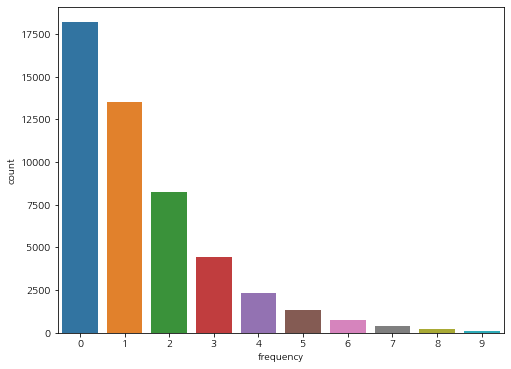

In [87]:
plt.figure(figsize=(8,6))
sns.countplot(x='frequency',data=train)

## 지역별

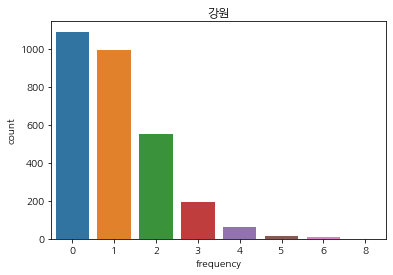

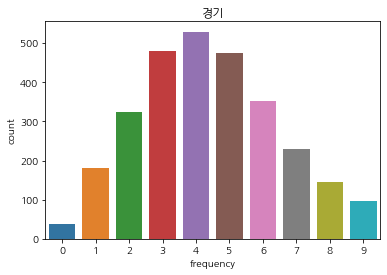

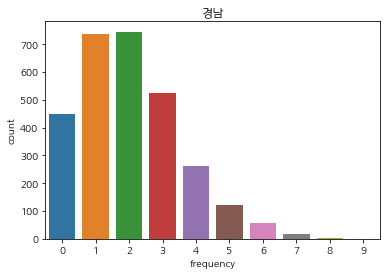

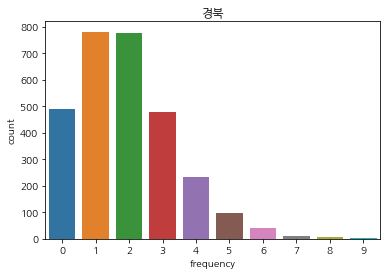

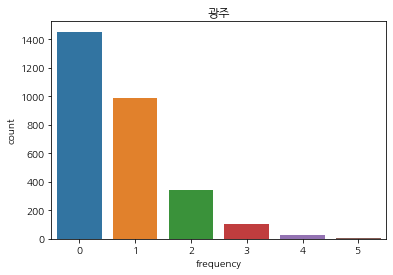

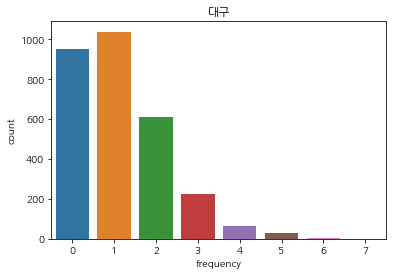

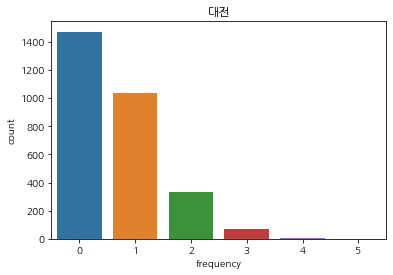

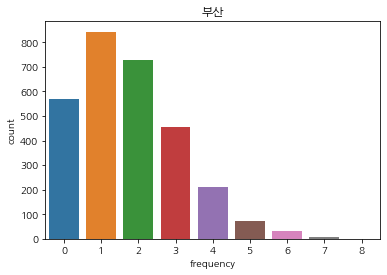

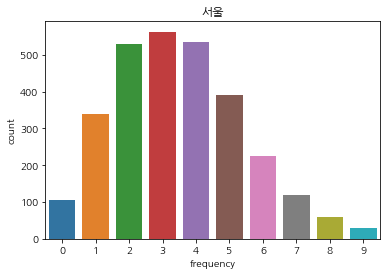

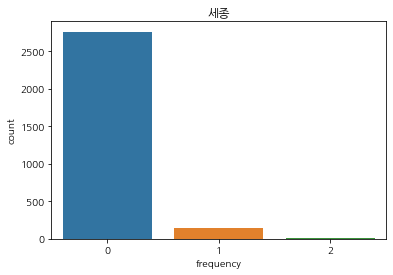

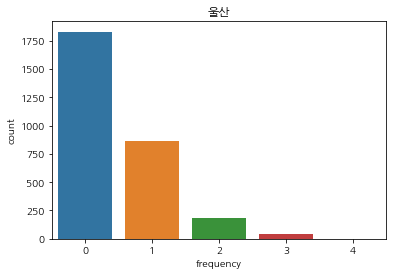

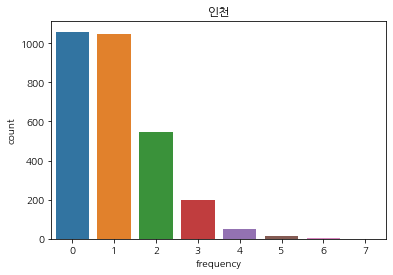

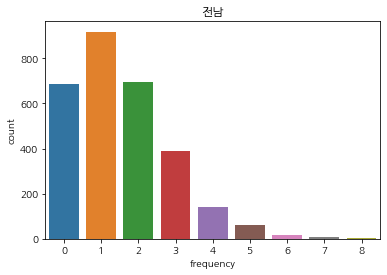

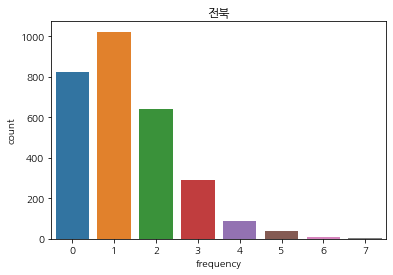

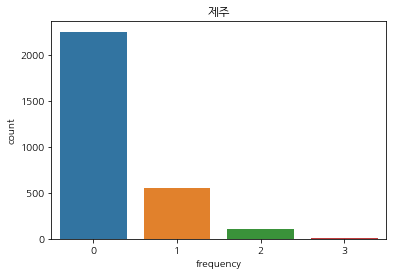

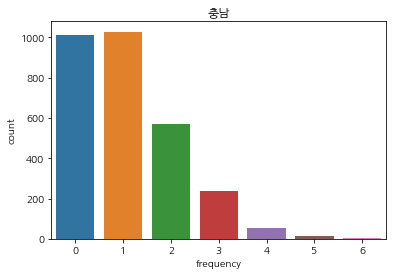

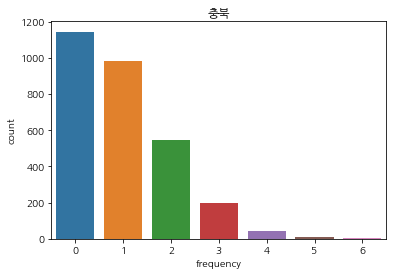

In [88]:
for area_ in train['area'].unique():
    plt.figure()
    sns.countplot(train[train['area']==area_]['frequency'])
    plt.title(area_)
    plt.show()

- 위의 그래프를 보면 인접한 지역(수도권, 영남(부산,경남,경북), 호서(충남,충북) 등)에 따라 비슷한 양상을 보임을 알 수 있음

추가적으로 지역별로 월별,일별 frequency를 확인

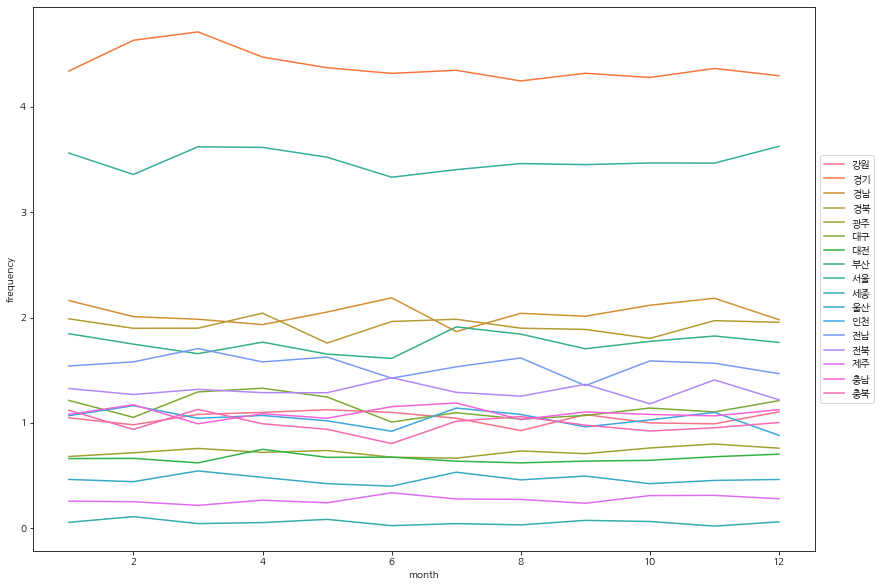

In [89]:
plt.figure(figsize=(14,10))
sns.lineplot(x='month',y='frequency',data=train,hue='area', ci = None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

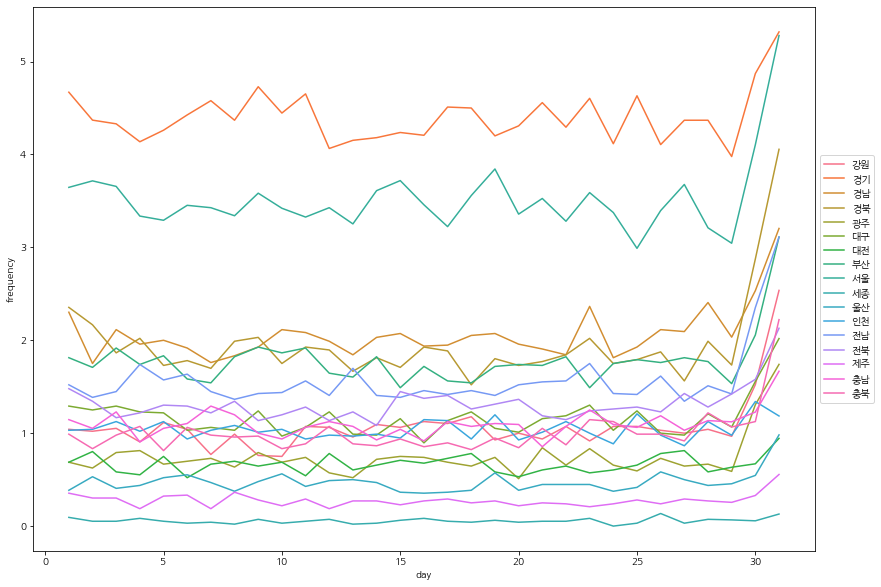

In [90]:
plt.figure(figsize=(14,10))
sns.lineplot(x='day',y='frequency',data=train,hue='area', ci = None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

- 위의 결과 지역별로 월별, 일별 frequency를 확인한 경우에는 주목할만한 부분은 발견되지 않음 

### 범주형 변수

In [91]:
# 범주형 변수에 대해 한 번에 시각화할 수 있는 함수
def plotfunction(x,z):
    figure,axes=plt.subplots(nrows=6,ncols=2)
    figure.set_size_inches(12,18)
    sns.barplot(x='area',y=z,data=x,ax=axes[0,0])
    sns.barplot(x='day',y=z,data=x,ax=axes[0,1])
    sns.barplot(x='season',y=z,data=x,ax=axes[1,0])
    sns.barplot(x='weekday',y=z,data=x,ax=axes[1,1])
    sns.barplot(x='holidays',y=z,data=x,ax=axes[2,0])
    sns.barplot(x='cold_wave',y=z,data=x,ax=axes[2,1])
    sns.barplot(x='last_class',y=z,data=x,ax=axes[3,0])
    sns.barplot(x='dtr_class',y=z,data=x,ax=axes[3,1])
    sns.barplot(x='fct_dtr_class',y=z,data=x,ax=axes[4,0])
    sns.barplot(x='pm10_class',y=z,data=x,ax=axes[4,1])
    sns.barplot(x='stroke',y=z,data=x,ax=axes[5,0])
    sns.barplot(x='elder_rate_class',y=z,data=x,ax=axes[5,1])

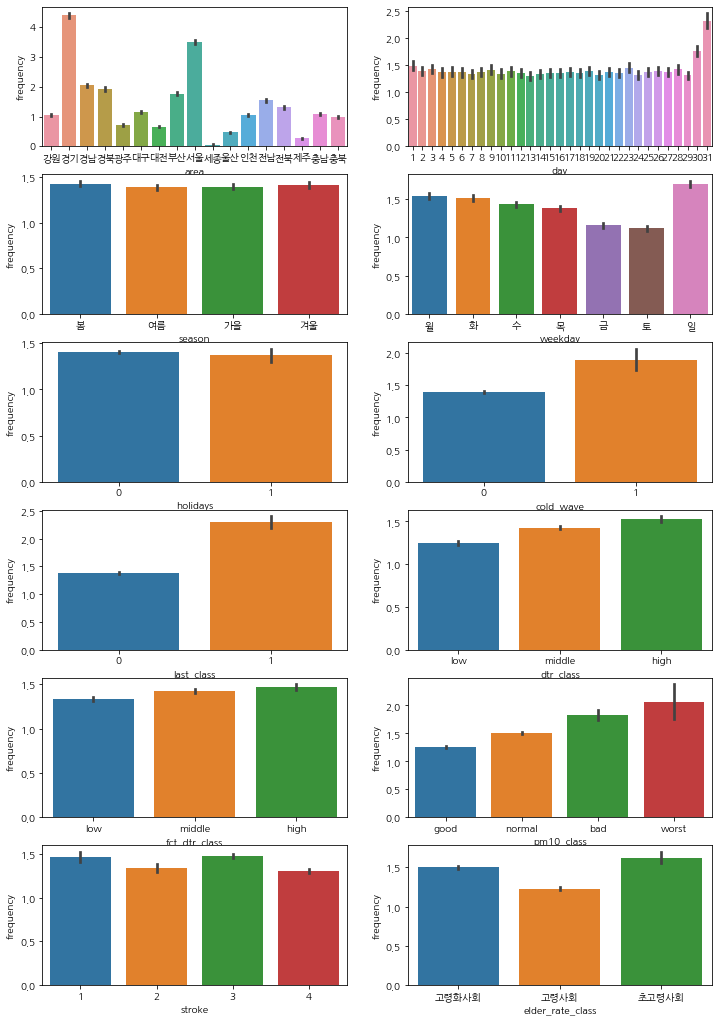

In [92]:
plotfunction(train,'frequency')

- frequency가 높게 나오는 경우에 대해 아래와 같은 특징을 발견

  지역의 경우 경기, 서울에 대해서, day에 대해서는 30~31일과 같은 월말에 특히 높게 나타났으며, 그에 따른 결과로 last_class 역시 월말인 경우에 frequency가 높게 나옴 
  
  그 외에도 한파인 날, 일교차가 높은 경우, 미세먼지 농도가 높을 수록, 뇌졸증 가능 지수가 1,3등급인 경우, 고령화 정도가 고령화 사회 및 초고령화사회인 경우에 frequency가 높게 나옴
  
  계절 및 공휴일은 큰 차이가 없음 


## 연속형 변수

In [93]:
#연속형 변수에 대해서 한 번에 lineplot을 그리는 함수 
def plotfunction_cont_box(x,z): 
    figure,axes=plt.subplots(nrows=6,ncols=2)
    figure.set_size_inches(14,16)
    sns.lineplot(y='ssrate',x=z,data=x,ax=axes[0,0],ci=None)
    sns.lineplot(y='sum_gsr',x=z,data=x,ax=axes[0,1],ci=None)
    sns.lineplot(y='avg_pa',x=z,data=x,ax=axes[1,0],ci=None)
    sns.lineplot(y='sum_rn',x=z,data=x,ax=axes[1,1],ci=None)
    sns.lineplot(y='avg_ta',x=z,data=x,ax=axes[2,0],ci=None)
    sns.lineplot(y='avg_ws',x=z,data=x,ax=axes[2,1],ci=None)
    sns.lineplot(y='pm10',x=z,data=x,ax=axes[3,0],ci=None)
    sns.lineplot(y='avg_rhm',x=z,data=x,ax=axes[3,1],ci=None)
    sns.lineplot(y='dtr',x=z,data=x,ax=axes[4,0],ci=None)
    sns.lineplot(y='fct_dtr',x=z,data=x,ax=axes[4,1],ci=None)
    sns.lineplot(y='wind_chill',x=z,data=x,ax=axes[5,0],ci=None)

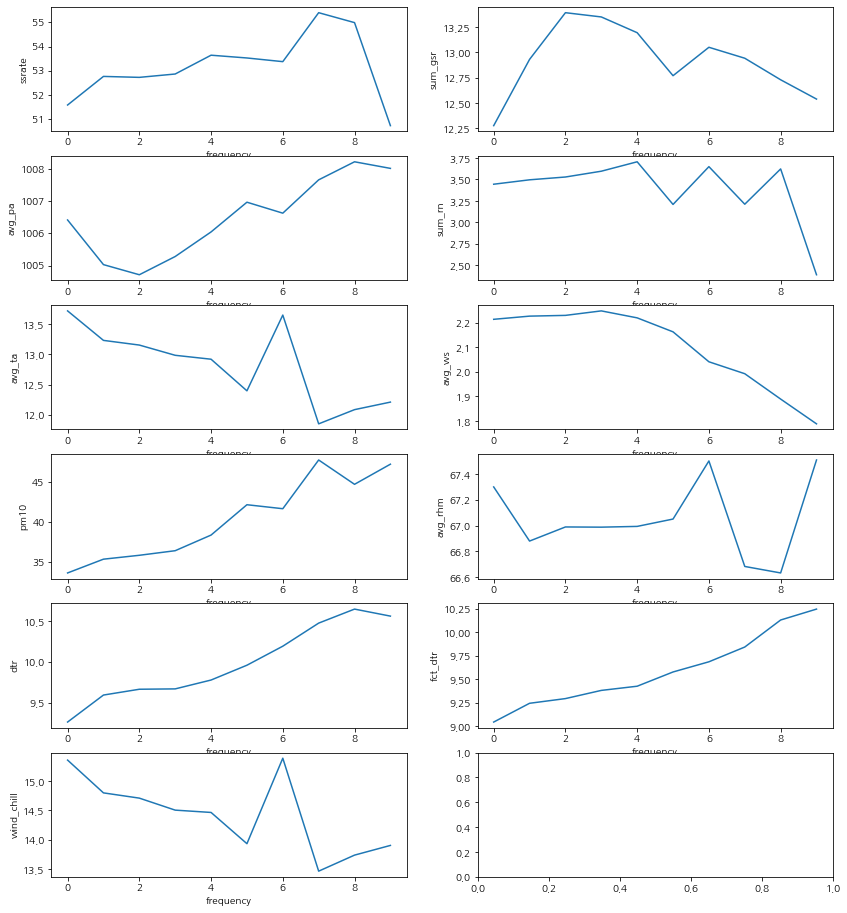

In [94]:
plotfunction_cont_box(train,'frequency')

- 전체적인 추세를 볼 때 일조율,평균기압,pm10,일교차,예보 일교차는 frequency에 대해 증가하는 경향을 보임.  
    평균기온,평균풍속,평균습도,체감온도는 전체적으로 봤을 때 frequency에 대해 감소하는 경향을 보임  
    합계전천일사,평균강수량은 frequency에 대해 특별한 추세가 발견되지 않음     

In [95]:
def plotfunction_cont_box2(x,z): 
    figure,axes=plt.subplots(nrows=4,ncols=2)
    figure.set_size_inches(14,16)
    sns.lineplot(y='max_pa',x=z,data=x,ax=axes[0,0],ci=None)
    sns.lineplot(y='min_pa',x=z,data=x,ax=axes[0,1],ci=None)
    sns.lineplot(y='max_ta',x=z,data=x,ax=axes[1,0],ci=None)
    sns.lineplot(y='min_ta',x=z,data=x,ax=axes[1,1],ci=None)
    sns.lineplot(y='fct_rhm',x=z,data=x,ax=axes[2,0],ci=None)
    sns.lineplot(y='fct_max_ta',x=z,data=x,ax=axes[2,1],ci=None)
    sns.lineplot(y='fct_min_ta',x=z,data=x,ax=axes[3,0],ci=None)

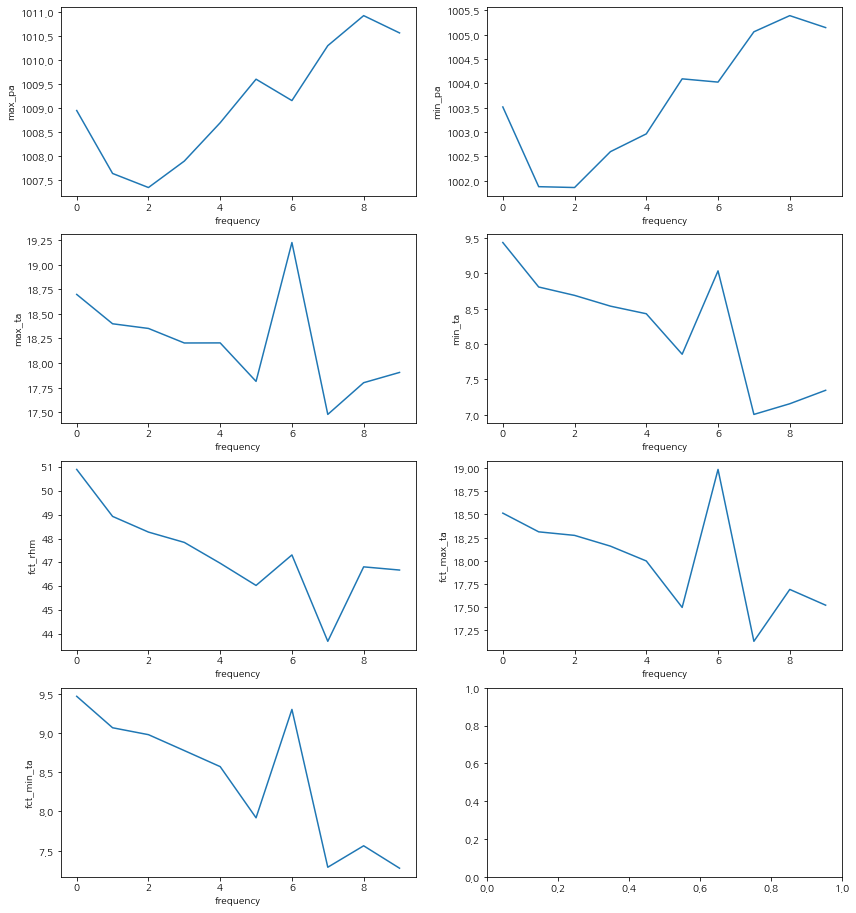

In [97]:
plotfunction_cont_box2(train,'frequency')

- 최고기압이랑 최저기압에 대해서는 frequency와 전체적인 추세로 볼 때 비례관계로 보이며,   
    예보습도,예보최고기온,예보최저기온,최고기온,최저기온 그와 반대의 결과. 

## 개인 특성 데이터

In [98]:
#1년치 데이터에 대해서만 별도로 그래프를 그리기 위한 함수
def plotfunction_year(x,z): 
    figure,axes=plt.subplots(nrows=3,ncols=2)
    figure.set_size_inches(14,16)
    sns.lineplot(y='EQ',x=z,data=x,ax=axes[0,0],ci=None)
    sns.lineplot(y='obesity',x=z,data=x,ax=axes[0,1],ci=None)
    sns.lineplot(y='smoking',x=z,data=x,ax=axes[1,0],ci=None)
    sns.lineplot(y='stress',x=z,data=x,ax=axes[1,1],ci=None)
    sns.lineplot(y='drink',x=z,data=x,ax=axes[2,0],ci=None)

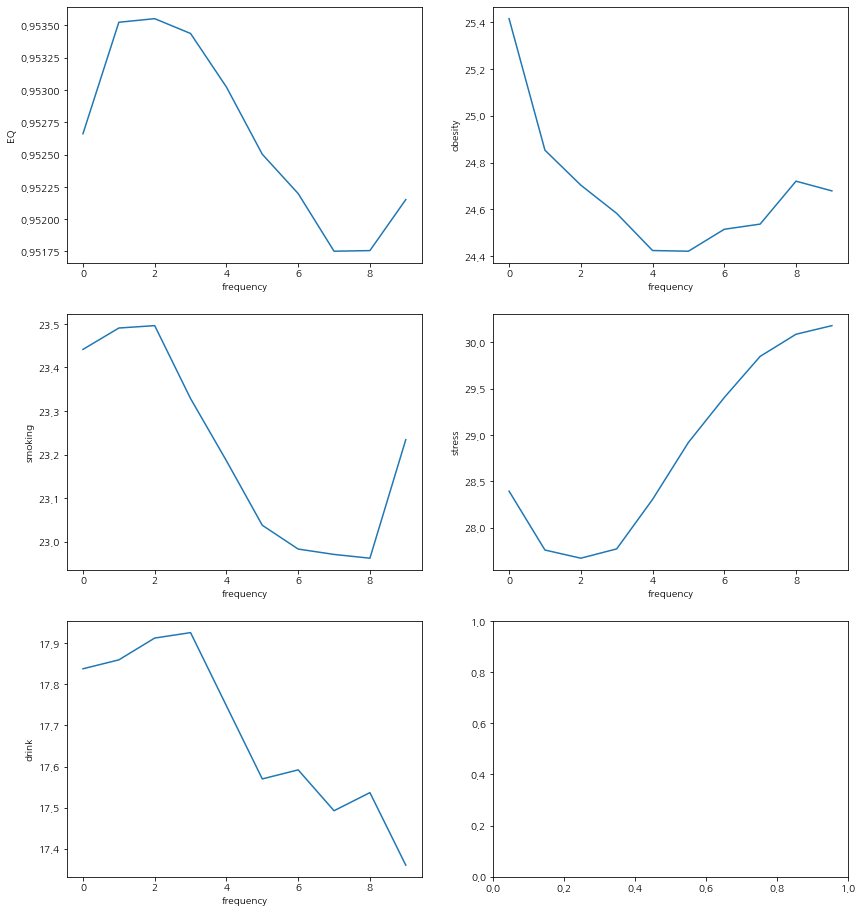

In [99]:
plotfunction_year(train,'frequency')

- 전체적으로 흡연/음주/EQ가 낮을 수록 높은 frequency를 보이며,
    스트레스는 반대의 경향을 보임.  
    비만율에 대해서는 4-5를 기점으로 freqeuency의 증감추세가 변화함 

위에서 영향이 있다고 판단되는 변수들 중 스트레스와 EQ를 연도별로 지역별 특징을 확인

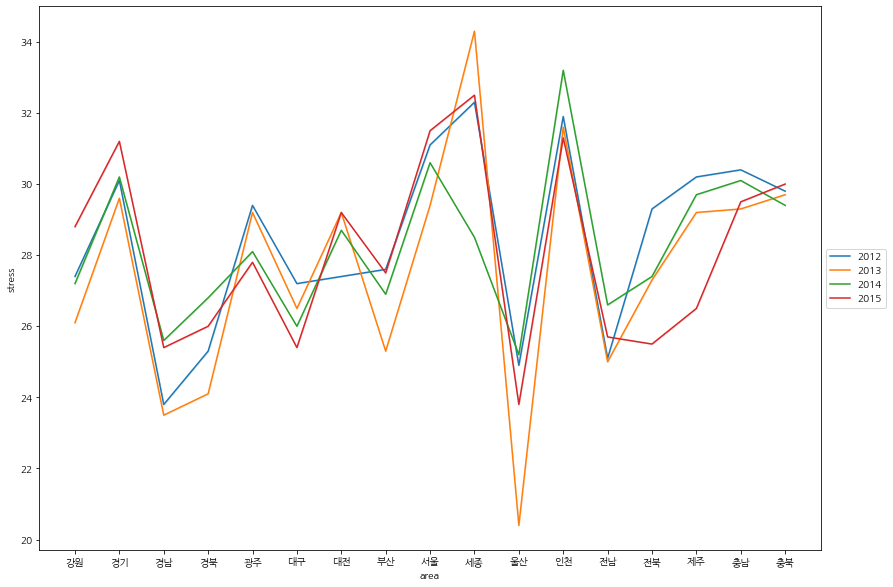

In [100]:
plt.figure(figsize=(14,10))
sns.lineplot(x='area',y='stress',data=train,hue='year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

- 수도권과 광역시 지역에 대해 스트레스 지수가 높게 나옴

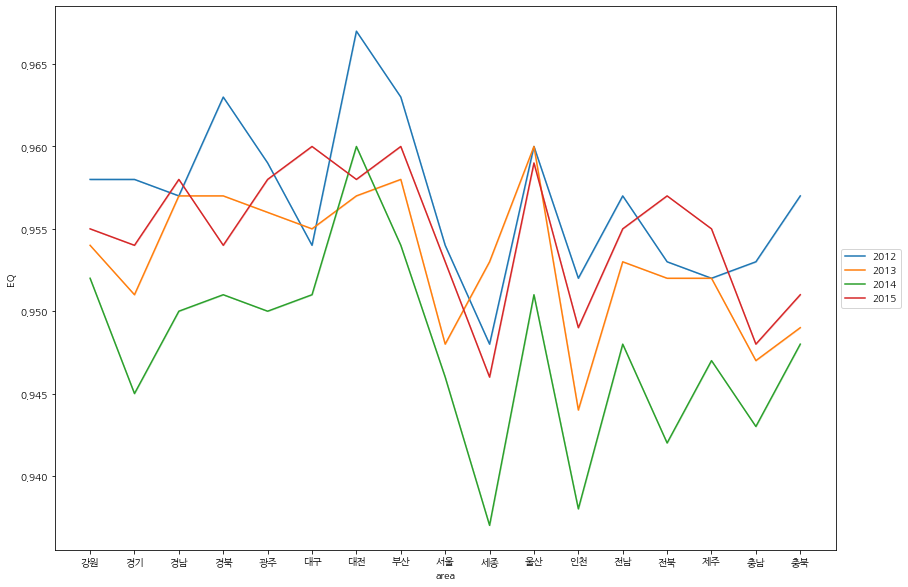

In [101]:
plt.figure(figsize=(14,10))
sns.lineplot(x='area',y='EQ',data=train,hue='year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

- 전체적으로 2014년은 EQ가 낮고 2012년이 높은 편이며 세종과 인천의 EQ가 낮음

1년치 데이터 by city

In [102]:
#city에 대해 1년치 데이터 그래프를 그리는 함수
def plotfunction_city(x,z): 
    figure,axes=plt.subplots(nrows=3,ncols=2)
    figure.set_size_inches(14,10)
    sns.lineplot(x = 'EQ', y =z, data = x, hue = 'city',ax=axes[0,0])
    sns.lineplot(x = 'obesity', y =z, data = x, hue = 'city',ax=axes[0,1])
    sns.lineplot(x = 'smoking', y =z, data = x, hue = 'city',ax=axes[1,0])
    sns.lineplot(x = 'stress', y =z, data = x, hue = 'city',ax=axes[1,1])
    sns.lineplot(x = 'drink', y =z, data = x, hue = 'city',ax=axes[2,0])

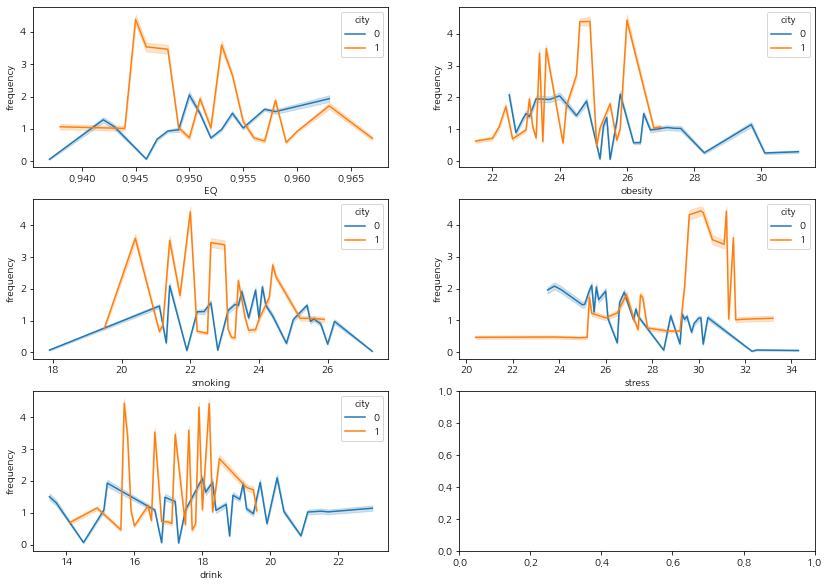

In [103]:
 plotfunction_city(train,'frequency')

## 뇌졸증가능지수

월별로 뇌졸중 가능 지수 확인  

<AxesSubplot:xlabel='month', ylabel='stroke'>

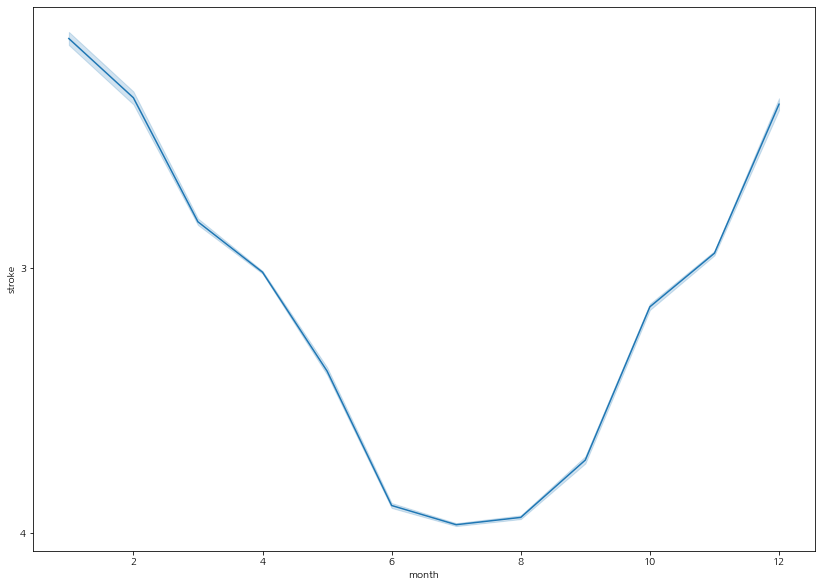

In [104]:
plt.figure(figsize=(14,10))
sns.lineplot(x='month',y='stroke',data=train)

- 뇌졸중 가능 지수가 높은 월 :  12, 1, 2월 -> 겨울에 주로 뇌졸증 가능 지수가 높아 보임  
    뇌졸중 가능 지수가 낮은 월 :  6, 7, 8월 -> 반대로 여름에는 뇌졸증 가능 지수가 낮게 나타남

뇌졸중 가능 지수 by city

<AxesSubplot:xlabel='stroke', ylabel='frequency'>

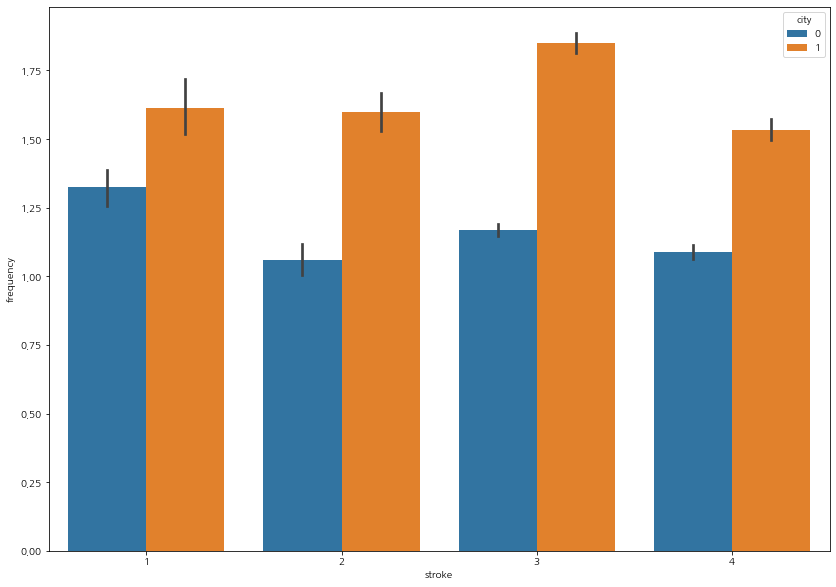

In [105]:
plt.figure(figsize=(14,10))
sns.barplot(x = 'stroke', y = 'frequency', data =train, hue = 'city',order=stroke_order)

전체적으로 수도권과 광역시에 대해 상대적으로 frequency가 높게 나타남